In [ ]:
# default_exp modeling.token_classification


In [ ]:
# all_slow


In [ ]:
#hide
%reload_ext autoreload
%autoreload 2
%matplotlib inline

# modeling.token_classification

> This module contains custom models, loss functions, custom splitters, etc... for token classification tasks (e.g., Named entity recognition (NER), Part-of-speech tagging (POS), etc...). The objective of token classification is to predict the correct label for each token provided in the input. In the computer vision world, this is akin to what we do in segmentation tasks whereby we attempt to predict the class/label for each pixel in an image.

In [ ]:
# export
import os, ast, inspect
from typing import Any, Callable, Dict, List, Optional, Union, Type

from fastcore.all import *
from fastai.callback.all import *
from fastai.data.block import DataBlock, ColReader, ItemGetter, ColSplitter, RandomSplitter
from fastai.data.core import DataLoader, DataLoaders, TfmdDL
from fastai.imports import *
from fastai.learner import *
from fastai.losses import CrossEntropyLossFlat
from fastai.optimizer import Adam, OptimWrapper, params
from fastai.metrics import perplexity
from fastai.torch_core import *
from fastai.torch_imports import *
from fastprogress.fastprogress import progress_bar, master_bar
from seqeval import metrics as seq_metrics
from transformers import AutoModelForTokenClassification, logging, PretrainedConfig, PreTrainedTokenizerBase, PreTrainedModel

from blurr.utils import BLURR
from blurr.data.core import HF_TextBlock, BlurrDataLoader, get_blurr_tfm, first_blurr_tfm
from blurr.modeling.core import HF_PreCalculatedLoss, Blearner
from blurr.data.token_classification import (
    get_token_labels_from_input_ids,
    get_word_labels_from_token_labels,
    HF_TokenClassInput,
    HF_TokenTensorCategory,
    HF_TokenCategorize,
    HF_TokenCategoryBlock,
    HF_TokenClassBeforeBatchTransform,
)

logging.set_verbosity_error()


In [ ]:
# hide_input
import pdb

from datasets import concatenate_datasets, load_dataset
from fastai.data.external import untar_data, URLs
from fastcore.test import *
from nbverbose.showdoc import show_doc
from transformers import AutoConfig

from blurr.utils import print_versions
from blurr.modeling.core import HF_BaseModelWrapper, HF_BaseModelCallback, HF_PreCalculatedLoss, hf_splitter

os.environ["TOKENIZERS_PARALLELISM"] = "false"
print("What we're running with at the time this documentation was generated:")
print_versions("torch fastai transformers")


What we're running with at the time this documentation was generated:
torch: 1.10.1+cu111
fastai: 2.5.3
transformers: 4.15.0


In [ ]:
# hide
# cuda
torch.cuda.set_device(1)
print(f"Using GPU #{torch.cuda.current_device()}: {torch.cuda.get_device_name()}")


Using GPU #1: GeForce GTX 1080 Ti


## Setup

We'll use a subset of `conll2003` to demonstrate how to configure your blurr code for token classification

In [ ]:
raw_datasets = load_dataset("conll2003")

labels = raw_datasets["train"].features["ner_tags"].feature.names
print(f'Labels: {labels}')

conll2003_df = pd.DataFrame(raw_datasets["train"])
conll2003_df.head()

Reusing dataset conll2003 (/home/wgilliam/.cache/huggingface/datasets/conll2003/conll2003/1.0.0/40e7cb6bcc374f7c349c83acd1e9352a4f09474eb691f64f364ee62eb65d0ca6)


  0%|          | 0/3 [00:00<?, ?it/s]

Labels: ['O', 'B-PER', 'I-PER', 'B-ORG', 'I-ORG', 'B-LOC', 'I-LOC', 'B-MISC', 'I-MISC']


,chunk_tags,id,ner_tags,pos_tags,tokens
0,"[11, 21, 11, 12, 21, 22, 11, 12, 0]",0,"[3, 0, 7, 0, 0, 0, 7, 0, 0]","[22, 42, 16, 21, 35, 37, 16, 21, 7]","[EU, rejects, German, call, to, boycott, British, lamb, .]"
1,"[11, 12]",1,"[1, 2]","[22, 22]","[Peter, Blackburn]"
2,"[11, 12]",2,"[5, 0]","[22, 11]","[BRUSSELS, 1996-08-22]"
3,"[11, 12, 12, 21, 13, 11, 11, 21, 13, 11, 12, 13, 11, 21, 22, 11, 12, 17, 11, 21, 17, 11, 12, 12, 21, 22, 22, 13, 11, 0]",3,"[0, 3, 4, 0, 0, 0, 0, 0, 0, 7, 0, 0, 0, 0, 0, 7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[12, 22, 22, 38, 15, 22, 28, 38, 15, 16, 21, 35, 24, 35, 37, 16, 21, 15, 24, 41, 15, 16, 21, 21, 20, 37, 40, 35, 21, 7]","[The, European, Commission, said, on, Thursday, it, disagreed, with, German, advice, to, consumers, to, shun, British, lamb, until, scientists, determine, whether, mad, cow, disease, can, be, transmitted, to, sheep, .]"
4,"[11, 11, 12, 13, 11, 12, 12, 11, 12, 12, 12, 12, 21, 13, 11, 12, 21, 22, 11, 13, 11, 1, 13, 11, 17, 11, 12, 12, 21, 1, 0]",4,"[5, 0, 0, 0, 0, 3, 4, 0, 0, 0, 1, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 0, 0, 0, 0, 0, 0, 0]","[22, 27, 21, 35, 12, 22, 22, 27, 16, 21, 22, 22, 38, 15, 22, 24, 20, 37, 21, 15, 24, 16, 15, 22, 15, 12, 16, 21, 38, 17, 7]","[Germany, 's, representative, to, the, European, Union, 's, veterinary, committee, Werner, Zwingmann, said, on, Wednesday, consumers, should, buy, sheepmeat, from, countries, other, than, Britain, until, the, scientific, advice, was, clearer, .]"


In [ ]:
model_cls = AutoModelForTokenClassification
pretrained_model_name = "roberta-base"
config = AutoConfig.from_pretrained(pretrained_model_name)

config.num_labels = len(labels)
hf_arch, hf_config, hf_tokenizer, hf_model = BLURR.get_hf_objects(pretrained_model_name, model_cls=model_cls, config=config)
hf_arch, type(hf_config), type(hf_tokenizer), type(hf_model)

('roberta',
 transformers.models.roberta.configuration_roberta.RobertaConfig,
 transformers.models.roberta.tokenization_roberta_fast.RobertaTokenizerFast,
 transformers.models.roberta.modeling_roberta.RobertaForTokenClassification)

Notice above how I set the `config.num_labels` attribute to the number of labels we want *our* model to be able to predict. The model will update its last layer accordingly (this concept is essentially transfer learning).

In [ ]:
test_eq(hf_config.num_labels, len(labels))


In [ ]:
before_batch_tfm = HF_TokenClassBeforeBatchTransform(hf_arch, hf_config, hf_tokenizer, hf_model)
blocks = (HF_TextBlock(before_batch_tfm=before_batch_tfm, input_return_type=HF_TokenClassInput), HF_TokenCategoryBlock(vocab=labels))

dblock = DataBlock(blocks=blocks, get_x=ColReader("tokens"), get_y=ColReader("ner_tags"), splitter=RandomSplitter())


In [ ]:
dls = dblock.dataloaders(conll2003_df, bs=4)


In [ ]:
dls.show_batch(dataloaders=dls, max_n=2)


,word / target label
0,"[('MARKET', 'O'), ('TALK', 'O'), ('-', 'O'), ('USDA', 'B-ORG'), ('net', 'O'), ('change', 'O'), ('in', 'O'), ('weekly', 'O'), ('export', 'O'), ('commitments', 'O'), ('for', 'O'), ('the', 'O'), ('week', 'O'), ('ended', 'O'), ('August', 'O'), ('22', 'O'), (',', 'O'), ('includes', 'O'), ('old', 'O'), ('crop', 'O'), ('and', 'O'), ('new', 'O'), ('crop', 'O'), (',', 'O'), ('were', 'O'), (':', 'O'), ('wheat', 'O'), ('up', 'O'), ('595,400', 'O'), ('tonnes', 'O'), ('old', 'O'), (',', 'O'), ('nil', 'O'), ('new', 'O'), (';', 'O'), ('corn', 'O'), ('up', 'O'), ('1,900', 'O'), ('old', 'O'), (',', 'O'), ('up', 'O'), ('319,600', 'O'), ('new', 'O'), (';', 'O'), ('soybeans', 'O'), ('down', 'O'), ('12,300', 'O'), ('old', 'O'), (',', 'O'), ('up', 'O'), ('300,800', 'O'), ('new', 'O'), (';', 'O'), ('upland', 'O'), ('cotton', 'O'), ('up', 'O'), ('50,400', 'O'), ('bales', 'O'), ('new', 'O'), (',', 'O'), ('nil', 'O'), ('old', 'O'), (';', 'O'), ('soymeal', 'O'), ('54,800', 'O'), ('old', 'O'), (',', 'O'), ('up', 'O'), ('100,600', 'O'), ('new', 'O'), (',', 'O'), ('soyoil', 'O'), ('nil', 'O'), ('old', 'O'), (',', 'O'), ('up', 'O'), ('75,000', 'O'), ('new', 'O'), (';', 'O'), ('barley', 'O'), ('up', 'O'), ('1,700', 'O'), ('old', 'O'), (',', 'O'), ('nil', 'O'), ('new', 'O'), (';', 'O'), ('sorghum', 'O'), ('6,200', 'O'), ('old', 'O'), (',', 'O'), ('up', 'O'), ('156,700', 'O'), ('new', 'O'), (';', 'O'), ('pima', 'O'), ('cotton', 'O'), ('up', 'O'), ('4,000', 'O'), ('bales', 'O'), ('old', 'O'), (',', 'O'), ('nil', 'O'), ('new', 'O'), (';', 'O'), ('rice', 'O'), ('up', 'O'), ('49,900', 'O'), ('old', 'O'), (',', 'O'), ('nil', 'O'), ('new', 'O'), ('...', 'O')]"
1,"[('""', 'O'), ('Our', 'O'), ('concern', 'O'), ('is', 'O'), ('to', 'O'), ('get', 'O'), ('out', 'O'), ('there', 'O'), ('and', 'O'), ('play', 'O'), ('proper', 'O'), ('cricket', 'O'), (',', 'O'), ('""', 'O'), ('Sri', 'B-LOC'), ('Lanka', 'I-LOC'), ('captain', 'O'), ('Arjuna', 'B-PER'), ('Ranatunga', 'I-PER'), ('told', 'O'), ('a', 'O'), ('news', 'O'), ('conference', 'O'), ('on', 'O'), ('the', 'O'), ('eve', 'O'), ('of', 'O'), ('a', 'O'), ('warmup', 'O'), ('match', 'O'), ('between', 'O'), ('the', 'O'), ('World', 'B-MISC'), ('Cup', 'I-MISC'), ('champions', 'O'), ('and', 'O'), ('a', 'O'), ('World', 'B-ORG'), ('XI', 'I-ORG'), ('team', 'O'), ('scheduled', 'O'), ('for', 'O'), ('Saturday', 'O'), ('.', 'O')]"


## Metrics

In this section, we'll add helpful metrics for token classification tasks

In [ ]:
# export
def calculate_token_class_metrics(pred_toks, targ_toks, metric_key):
    if metric_key == "accuracy":
        return seq_metrics.accuracy_score(targ_toks, pred_toks)

    if metric_key == "precision":
        return seq_metrics.precision_score(targ_toks, pred_toks)

    if metric_key == "recall":
        return seq_metrics.recall_score(targ_toks, pred_toks)

    if metric_key == "f1":
        return seq_metrics.f1_score(targ_toks, pred_toks)

    if metric_key == "classification_report":
        return seq_metrics.classification_report(targ_toks, pred_toks)


### `HF_TokenClassMetricsCallback`

In [ ]:
# export
class HF_TokenClassMetricsCallback(Callback):
    """
    A fastai friendly callback that includes accuracy, precision, recall, and f1 metrics using the
    `seqeval` library.  Additionally, this metric knows how to *not* include your 'ignore_token' in it's
    calculations.

    See [here](https://github.com/chakki-works/seqeval) for more information on `seqeval`.
    """

    def __init__(self, tok_metrics=["accuracy", "precision", "recall", "f1"], **kwargs):
        self.run_before = Recorder

        store_attr(self=self, names="tok_metrics, kwargs")
        self.custom_metrics_dict = {k: None for k in tok_metrics}

        self.do_setup = True

    def setup(self):
        # one time setup code here.
        if not self.do_setup:
            return

        # grab the hf_tokenizer from the HF_TokenClassBeforeBatchTransform
        tfm = first_blurr_tfm(self.learn.dls, before_batch_tfm_class=HF_TokenClassBeforeBatchTransform)
        hf_tok_categorize_tfm = get_blurr_tfm(self.learn.dls.tfms[1], tfm_class=HF_TokenCategorize)

        self.hf_tokenizer = tfm.hf_tokenizer
        self.ignore_label_token_id = hf_tok_categorize_tfm.ignore_token_id
        self.tok_special_symbols = list(self.hf_tokenizer.special_tokens_map.values())
        self.tok_kwargs = tfm.kwargs

        # add custom text generation specific metrics
        custom_metric_keys = self.custom_metrics_dict.keys()
        custom_metrics = L([ValueMetric(partial(self.metric_value, metric_key=k), k) for k in custom_metric_keys])
        self.learn.metrics = self.learn.metrics + custom_metrics
        self.learn.token_classification_report = None

        self.do_setup = False

    def before_fit(self):
        self.setup()

    # --- batch begin/after phases ---
    def after_batch(self):
        if self.training or self.learn.y is None:
            return

        # do this only for validation set
        preds = self.pred.argmax(dim=-1)
        targs = self.yb[0]  # yb is TensorText tuple, item 0 is the data

        preds_list, targets_list = [], []
        for i in range(targs.shape[0]):
            item_targs, item_preds = [], []

            for j in range(targs.shape[1]):
                if targs[i, j] != self.ignore_label_token_id:
                    item_preds.append(self.dls.vocab[preds[i][j].item()])
                    item_targs.append(self.dls.vocab[targs[i][j].item()])

            preds_list.append(item_preds)
            targets_list.append(item_targs)

        self.results += [(res[0], res[1]) for res in zip(preds_list, targets_list)]

    # --- validation begin/after phases ---
    def before_validate(self):
        self.results = []

    def after_validate(self):
        if len(self.results) < 1:
            return

        preds, targs = map(list, zip(*self.results))
        for k in self.custom_metrics_dict.keys():
            self.custom_metrics_dict[k] = calculate_token_class_metrics(targs, preds, metric_key=k)

        try:
            self.learn.token_classification_report = calculate_token_class_metrics(targs, preds, "classification_report")
        except ZeroDivisionError as err:
            print(f"Couldn't calcualte classification report: {err}")

    # --- for ValueMetric metrics ---
    def metric_value(self, metric_key):
        return self.custom_metrics_dict[metric_key]


## Mid-level API

### Training

In [ ]:
model = HF_BaseModelWrapper(hf_model)
learn_cbs = [HF_BaseModelCallback]
fit_cbs = [HF_TokenClassMetricsCallback()]

learn = Learner(dls, model, opt_func=partial(Adam), cbs=learn_cbs, splitter=hf_splitter)

learn.freeze()


In [ ]:
# hide_output
# learn.summary()


In [ ]:
b = dls.one_batch()
preds = learn.model(b[0])
len(preds), preds[0].shape


(1, torch.Size([4, 156, 9]))

In [ ]:
len(b), len(b[0]), b[0]["input_ids"].shape, len(b[1]), b[1].shape


(2, 2, torch.Size([4, 156]), 4, torch.Size([4, 156]))

In [ ]:
print(preds[0].view(-1, preds[0].shape[-1]).shape, b[1].view(-1).shape)
test_eq(preds[0].view(-1, preds[0].shape[-1]).shape[0], b[1].view(-1).shape[0])


torch.Size([624, 9]) torch.Size([624])


In [ ]:
print(len(learn.opt.param_groups))


3


SuggestedLRs(minimum=0.003981071710586548, steep=5.248074739938602e-05, valley=0.0006918309954926372, slide=0.0063095735386013985)

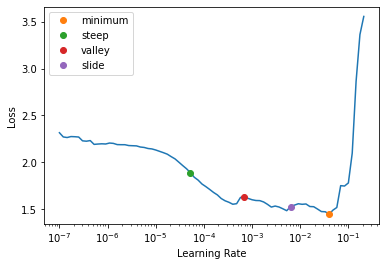

In [ ]:
learn.unfreeze()
learn.lr_find(suggest_funcs=[minimum, steep, valley, slide])


In [ ]:
learn.fit_one_cycle(1, lr_max=3e-5, moms=(0.8, 0.7, 0.8), cbs=fit_cbs)


epoch,train_loss,valid_loss,accuracy,precision,recall,f1,time
0,0.067634,0.052211,0.988454,0.936106,0.930322,0.933205,03:16


In [ ]:
print(learn.token_classification_report)


              precision    recall  f1-score   support

         LOC       0.96      0.95      0.95      1445
        MISC       0.85      0.87      0.86       652
         ORG       0.91      0.90      0.91      1295
         PER       0.98      0.96      0.97      1301

   micro avg       0.94      0.93      0.93      4693
   macro avg       0.93      0.92      0.92      4693
weighted avg       0.94      0.93      0.93      4693



### `show_results`

Below we'll add in additional functionality to more intuitively show the results of our model.

In [ ]:
# export
@typedispatch
def show_results(
    # This typedispatched `show_results` will be called for `HF_TokenClassInput` typed inputs
    x: HF_TokenClassInput,
    # This typedispatched `show_results` will be called for `HF_TokenTensorCategory` typed targets
    y: HF_TokenTensorCategory,
    # Your raw inputs/targets
    samples,
    # The model's predictions
    outs,
    # Your `Learner`. This is required so as to get at the Hugging Face objects for decoding them into
    # something understandable
    learner,
    # Your `show_results` context
    ctxs=None,
    # The maximum number of items to show
    max_n=6,
    # Any truncation your want applied to your decoded inputs
    trunc_at=None,
    # Any other keyword arguments you want applied to `show_results`
    **kwargs,
):
    tfm = first_blurr_tfm(learner.dls, before_batch_tfm_class=HF_TokenClassBeforeBatchTransform)
    hf_arch, hf_tokenizer = tfm.hf_arch, tfm.hf_tokenizer
    ignore_token_id = tfm.ignore_token_id
    vocab = learner.dls.vocab

    res = L()
    for inp, trg, sample, pred in zip(x, y, samples, outs):
        # align "tokens" with labels
        tok_labels = get_token_labels_from_input_ids(hf_tokenizer, inp, trg, vocab)
        # align "words" with labels
        word_labels = get_word_labels_from_token_labels(hf_arch, hf_tokenizer, tok_labels)
        # align "words" with "predicted" labels
        word_pred_labels = [pred_lbl for lbl_id, pred_lbl in zip(trg, ast.literal_eval(pred[0])) if lbl_id != ignore_token_id]

        # stringify list of (word,label) for example
        res.append(
            [
                f"{[ (word_targ[0], word_targ[1], pred_targ) for idx, (word_targ, pred_targ) in enumerate(zip(word_labels, word_pred_labels)) if (trunc_at is None or idx < trunc_at) ]}"
            ]
        )

    display_df(pd.DataFrame(res, columns=["token / target label / predicted label"])[:max_n])
    return ctxs


In [ ]:
learn.show_results(learner=learn, max_n=2, trunc_at=10)


,token / target label / predicted label
0,"[('Even', 'O', 'O'), ('though', 'O', 'O'), ('more', 'O', 'O'), ('than', 'O', 'O'), ('40', 'O', 'O'), ('million', 'O', 'O'), ('copies', 'O', 'O'), ('of', 'O', 'O'), ('Windows', 'B-MISC', 'B-MISC'), ('95', 'I-MISC', 'I-MISC')]"
1,"[('Dutroux', 'B-PER', 'B-PER'), (',', 'O', 'O'), ('39', 'O', 'O'), (',', 'O', 'O'), ('who', 'O', 'O'), ('was', 'O', 'O'), ('charged', 'O', 'O'), ('last', 'O', 'O'), ('week', 'O', 'O'), ('with', 'O', 'O')]"


In [ ]:
res = learn.blurr_predict("My name is Wayde and I live in San Diego".split())
print(res[0][0])


("['O', 'O', 'O', 'O', 'B-PER', 'I-PER', 'O', 'O', 'O', 'O', 'B-LOC', 'I-LOC', 'O']",)


### `blurr_predict_tokens`

The default `Learner.predict` method returns a prediction per subtoken, including the special tokens for each architecture's tokenizer. Starting with version 2.0 of Blurr, we bring token prediction in-line with Hugging Face's token classification pipeline, both in terms of supporting the same aggregation strategies via Blurr's `TokenAggregationStrategies` class, and also the output via Blurr's `@patch`ed `Learner` method, `blurr_predict_tokens`.

In [ ]:
#export
class TokenAggregationStrategies():
    """ 
    Provides the equivalanet of Hugging Face's token classification pipeline's `aggregation_strategy` support across various 
    token classication tasks (e.g, NER, POS, chunking, etc...)
    """
    def __init__(self, hf_tokenizer: PreTrainedTokenizerBase, labels: List[str], non_entity_label: str = "O") -> None:
        self.hf_tokenizer = hf_tokenizer
        self.labels = labels
        self.non_entity_label = non_entity_label
        self.valid_strategies = ["simple", "first", "max", "average"]

    def by_token(self, tokens, input_ids, offsets, preds, probs):
        results = []
        for tok_idx, (token, input_id, offset, pred, prob) in enumerate(zip(tokens, input_ids, offsets, preds, probs)):
            # pass over any non-entity labels and "special" tokens
            label = self.labels[pred]
            if label == self.non_entity_label or input_id.item() in self.hf_tokenizer.all_special_ids:
                continue

            start, end = offset
            results.append({"entity": label, "score": prob[pred], "word": token, "start": start.item(), "end": end.item()})

        return results

    def by_word_strategy(self, strategy_name, text, input_ids, offsets, preds, probs, word_ids=None):
        # validate `strategy_name`
        if strategy_name not in self.valid_strategies:
            raise ValueError("The 'strategy_name' is not supported by this class")

        # validate the existence of `word_ids` if the aggregation strategy = "average"
        if strategy_name == "average" and word_ids is None:
            raise ValueError("The 'average' strategy requires word_ids list")

        results = []
        idx = 0
        while idx < len(preds):
            pred = preds[idx]
            label = self.labels[pred]

            # pass over any non-entity labels and "special" tokens
            if label == self.non_entity_label or input_ids[idx].item() in self.hf_tokenizer.all_special_ids:
                idx += 1
                continue
            
            # Remove the B- or I-
            label = label[2:]
            start, end = offsets[idx]

            all_scores = []
            all_scores.append(probs[idx][pred])

            word_scores = {}
            if strategy_name == "average":
                word_scores[word_ids[idx]] = [probs[idx][pred]]

            while (
                idx+1 < len(preds)
                and self.labels[preds[idx+1]] == f"I-{label}"
            ):
                idx += 1
                _, end = offsets[idx]

                pred = preds[idx]

                if strategy_name == "average":
                    if word_ids[idx] in word_scores:
                        word_scores[word_ids[idx]].append(probs[idx][pred])
                    else:
                        word_scores[word_ids[idx]] = [probs[idx][pred]]
                
                if strategy_name != "first":
                    all_scores.append(probs[idx][pred])

            # The score is the mean of all the scores of the tokens in that grouped entity
            if strategy_name == "average":
                score = np.mean([np.mean(v).item() for k,v in word_scores.items()])
            else:
                score = np.max(all_scores).item() if strategy_name == 'max' else np.mean(all_scores).item()

            word = text[start:end]
            results.append({"entity_group": label, "score": score, "word": word, "start": start.item(), "end": end.item()})

            idx += 1

        return results

In [ ]:
# export
@patch
def blurr_predict_tokens(
    self: Learner,
    # The str (or list of strings) you want to get token classification predictions for
    items: Union[str, List[str]],
    # How entities are grouped and scored
    aggregation_strategy: str = "simple",
    # The label used to idendity non-entity related words/tokens
    non_entity_label: str = "O",
    # If using a slow tokenizer, users will need to prove a `slow_word_ids_func` that accepts a 
    # tokenizzer, example index, and a batch encoding as arguments and in turn returnes the 
    # equavlient of fast tokenizer's `word_ids``
    slow_word_ids_func: Optional[Callable] = None,
):
    if not is_listy(items):
        items = [items]

    tfm = first_blurr_tfm(self.dls, before_batch_tfm_class=HF_TokenClassBeforeBatchTransform)
    hf_tokenizer = tfm.hf_tokenizer

    strategies = TokenAggregationStrategies(hf_tokenizer, self.dls.vocab, non_entity_label)

    inputs = hf_tokenizer(items, return_offsets_mapping=True, return_tensors="pt", padding=True, truncation=True)
    inputs_offsets = inputs["offset_mapping"]
    inputs_input_ids = inputs["input_ids"]

    # run inputs through model
    model_inputs = {k: v.to(learn.model.hf_model.device) for k, v in inputs.items()}
    outputs = learn.model(model_inputs)

    # fetch probabilities and predictions
    probabilities = F.softmax(outputs.logits, dim=-1).tolist()
    predictions = outputs.logits.argmax(dim=-1).tolist()

    # build our results
    results = []
    for input_idx, (text, input_ids, offsets, preds, probs) in enumerate(zip(items, inputs_input_ids, inputs_offsets, predictions, probabilities)):
        # build our results for the current input
        tokens = inputs.tokens(input_idx)
        word_ids = inputs.word_ids(input_idx) if hf_tokenizer.is_fast else slow_word_ids_func(hf_tokenizer, input_idx, inputs)

        if aggregation_strategy == "token":
            results.append(strategies.by_token(tokens, input_ids, offsets, preds, probs))
        else:
            results.append(strategies.by_word_strategy(aggregation_strategy, text, input_ids, offsets, preds, probs, word_ids))
    return results


In [ ]:
show_doc(Learner.blurr_predict_tokens)


<h4 id="Learner.blurr_predict_tokens" class="doc_header"><code>Learner.blurr_predict_tokens</code><a href="__main__.py#L2" class="source_link" style="float:right">[source]</a></h4>

> <code>Learner.blurr_predict_tokens</code>(**`items`**:`Union`\[`str`, `List`\[`str`\]\], **`aggregation_strategy`**:`str`=*`'simple'`*, **`non_entity_label`**:`str`=*`'O'`*, **`slow_word_ids_func`**:`Optional`\[`Callable`\]=*`None`*)



**Parameters:**


 - **`items`** : *`typing.Union[str, typing.List[str]]`*	<p>The str (or list of strings) you want to get token classification predictions for</p>


 - **`aggregation_strategy`** : *`<class 'str'>`*, *optional*	<p>How entities are grouped and scored</p>


 - **`non_entity_label`** : *`<class 'str'>`*, *optional*	<p>The label used to idendity non-entity related words/tokens</p>


 - **`slow_word_ids_func`** : *`typing.Optional[typing.Callable]`*, *optional*	<p>If using a slow tokenizer, users will need to prove a `slow_word_ids_func` that accepts a 
tokenizzer, example index, and a batch encoding as arguments and in turn returnes the 
equavlient of fast tokenizer's `word_ids``</p>



In [ ]:
res = learn.blurr_predict_tokens(
    items=["My name is Wayde and I live in San Diego and using Hugging Face", "Bayern Munich is a soccer team in Germany"],
    aggregation_strategy="max",
)

print(len(res))
print(res[1])


2
[{'entity_group': 'ORG', 'score': 0.9959740042686462, 'word': 'Bayern Munich', 'start': 0, 'end': 13}, {'entity_group': 'LOC', 'score': 0.9976871013641357, 'word': 'Germany', 'start': 34, 'end': 41}]


In [ ]:
txt = "Hi! My name is Wayde Gilliam from ohmeow.com. I live in California."
txt2 = "I wish covid was over so I could go to Germany and watch Bayern Munich play in the Bundesliga."


In [ ]:
res = learn.blurr_predict_tokens(txt)
print(res)


[[{'entity_group': 'PER', 'score': 0.9956589937210083, 'word': 'Way', 'start': 15, 'end': 18}, {'entity_group': 'PER', 'score': 0.8589259386062622, 'word': 'de Gilliam', 'start': 18, 'end': 28}, {'entity_group': 'ORG', 'score': 0.3627583185831706, 'word': 'ohmeow', 'start': 34, 'end': 40}, {'entity_group': 'LOC', 'score': 0.99620121717453, 'word': 'California', 'start': 56, 'end': 66}]]


In [ ]:
results = learn.blurr_predict_tokens([txt, txt2])
for res in results:
    print(f"{res}\n")


[{'entity_group': 'PER', 'score': 0.9956589937210083, 'word': 'Way', 'start': 15, 'end': 18}, {'entity_group': 'PER', 'score': 0.8589259386062622, 'word': 'de Gilliam', 'start': 18, 'end': 28}, {'entity_group': 'ORG', 'score': 0.3627583185831706, 'word': 'ohmeow', 'start': 34, 'end': 40}, {'entity_group': 'LOC', 'score': 0.99620121717453, 'word': 'California', 'start': 56, 'end': 66}]

[{'entity_group': 'LOC', 'score': 0.9965722560882568, 'word': 'Germany', 'start': 39, 'end': 46}, {'entity_group': 'ORG', 'score': 0.9590863287448883, 'word': 'Bayern Munich', 'start': 57, 'end': 70}, {'entity_group': 'MISC', 'score': 0.9170079231262207, 'word': 'Bundesliga', 'start': 83, 'end': 93}]



### Inference

In [ ]:
export_fname = "tok_class_learn_export"


In [ ]:
learn.export(fname=f"{export_fname}.pkl")
inf_learn = load_learner(fname=f"{export_fname}.pkl")

results = inf_learn.blurr_predict_tokens([txt, txt2])
for res in results:
    print(f"{res}\n")


[{'entity_group': 'PER', 'score': 0.9956589937210083, 'word': 'Way', 'start': 15, 'end': 18}, {'entity_group': 'PER', 'score': 0.8589259386062622, 'word': 'de Gilliam', 'start': 18, 'end': 28}, {'entity_group': 'ORG', 'score': 0.3627583185831706, 'word': 'ohmeow', 'start': 34, 'end': 40}, {'entity_group': 'LOC', 'score': 0.99620121717453, 'word': 'California', 'start': 56, 'end': 66}]

[{'entity_group': 'LOC', 'score': 0.9965722560882568, 'word': 'Germany', 'start': 39, 'end': 46}, {'entity_group': 'ORG', 'score': 0.9590863287448883, 'word': 'Bayern Munich', 'start': 57, 'end': 70}, {'entity_group': 'MISC', 'score': 0.9170079231262207, 'word': 'Bundesliga', 'start': 83, 'end': 93}]



## High-level API

### `BLearnerForTokenClassification`

In [ ]:
# hide
try:
    del learn
    del inf_learn
    torch.cuda.empty_cache()
except:
    pass


In [ ]:
# export
@delegates(Blearner.__init__)
class BlearnerForTokenClassification(Blearner):
    def __init__(self, dls: DataLoaders, hf_model: PreTrainedModel, **kwargs):
        super().__init__(dls, hf_model, **kwargs)

    @classmethod
    def get_model_cls(self):
        return AutoModelForTokenClassification

    @classmethod
    def get_metrics_cb(self):
        return HF_TokenClassMetricsCallback()

    @classmethod
    def _create_learner(
        cls,
        # Your raw dataset
        data,
        # The name or path of the pretrained model you want to fine-tune
        pretrained_model_name_or_path: Optional[Union[str, os.PathLike]],
        # A function to perform any preprocessing required for your Dataset
        preprocess_func: Callable = None,
        # The attribute in your dataset that contains a list of your tokens
        tokens_attr: List[str] = "tokens",
        # The attribute in your dataset that contains the entity labels for each token in your raw text
        token_labels_attr: List[str] = "token_labels",
        # The unique entity labels (or vocab) available in your dataset
        labels: List[str] = None,
        # A function that will split your Dataset into a training and validation set
        # See [here](https://docs.fast.ai/data.transforms.html#Split) for a list of fast.ai splitters
        dblock_splitter: Callable = RandomSplitter(),
        # Any kwargs to pass to your `DataLoaders`
        dl_kwargs: dict = {},
        # Any kwargs to pass to your task specific `Blearner`
        learner_kwargs: dict = {}
    ):
        # get our hf objects
        n_labels = len(labels)
        hf_arch, hf_config, hf_tokenizer, hf_model = BLURR.get_hf_objects(
            pretrained_model_name_or_path, model_cls=cls.get_model_cls(), config_kwargs={"num_labels": n_labels}
        )

        # if we need to preprocess the raw data before creating our DataLoaders
        if preprocess_func:
            data = preprocess_func(data, hf_arch, hf_config, hf_tokenizer, hf_model, tokens_attr, token_labels_attr, labels)

        # not all architectures include a native pad_token (e.g., gpt2, ctrl, etc...), so we add one here
        if hf_tokenizer.pad_token is None:
            hf_tokenizer.add_special_tokens({"pad_token": "<pad>"})
            hf_config.pad_token_id = hf_tokenizer.get_vocab()["<pad>"]
            hf_model.resize_token_embeddings(len(hf_tokenizer))

        # build getters
        if isinstance(data, pd.DataFrame):
            get_x = ColReader(tokens_attr)
            get_y = ColReader(token_labels_attr)
        else:
            get_x = ItemGetter(tokens_attr)
            get_y = ItemGetter(token_labels_attr)

        before_batch_tfm = HF_TokenClassBeforeBatchTransform(hf_arch, hf_config, hf_tokenizer, hf_model)

        blocks = (
            HF_TextBlock(before_batch_tfm=before_batch_tfm, input_return_type=HF_TokenClassInput),
            HF_TokenCategoryBlock(vocab=labels),
        )

        dblock = DataBlock(blocks=blocks, get_x=get_x, get_y=get_y, splitter=dblock_splitter)

        dls = dblock.dataloaders(data, **dl_kwargs.copy())

        # return BLearner instance
        return cls(dls, hf_model, **learner_kwargs.copy())

    @classmethod
    def from_dataframe(
        cls,
        # Your pandas DataFrame
        df: pd.DataFrame,
        # The name or path of the pretrained model you want to fine-tune
        pretrained_model_name_or_path: Optional[Union[str, os.PathLike]],
        # A function to perform any preprocessing required for your Dataset
        preprocess_func: Callable = None,
        # The attribute in your dataset that contains a list of your tokens
        tokens_attr: List[str] = "tokens",
        # The attribute in your dataset that contains the entity labels for each token in your raw text
        token_labels_attr: List[str] = "token_labels",
        # The unique entity labels (or vocab) available in your dataset
        labels: List[str] = None,
        # A function that will split your Dataset into a training and validation set
        # See [here](https://docs.fast.ai/data.transforms.html#Split) for a list of fast.ai splitters
        dblock_splitter: Callable = ColSplitter(),
        # Any kwargs to pass to your `DataLoaders`
        dl_kwargs: dict = {},
        # Any kwargs to pass to your task specific `Blearner`
        learner_kwargs: dict = {}
    ):
        # we need to tell transformer how many labels/classes to expect
        if labels is None:
            labels = sorted(list(set([lbls for sublist in df[token_labels_attr].tolist() for lbls in sublist])))

        return cls._create_learner(
            df,
            pretrained_model_name_or_path,
            preprocess_func,
            tokens_attr,
            token_labels_attr,
            labels,
            dblock_splitter,
            dl_kwargs,
            learner_kwargs,
        )

    @classmethod
    def from_csv(
        cls,
        # The path to your csv file
        csv_file: Union[Path, str],
        # The name or path of the pretrained model you want to fine-tune
        pretrained_model_name_or_path: Optional[Union[str, os.PathLike]],
        # A function to perform any preprocessing required for your Dataset
        preprocess_func: Callable = None,
        # The attribute in your dataset that contains a list of your tokens
        tokens_attr: List[str] = "tokens",
        # The attribute in your dataset that contains the entity labels for each token in your raw text
        token_labels_attr: List[str] = "token_labels",
        # The unique entity labels (or vocab) available in your dataset
        labels: List[str] = None,
        # A function that will split your Dataset into a training and validation set
        # See [here](https://docs.fast.ai/data.transforms.html#Split) for a list of fast.ai splitters
        dblock_splitter: Callable = ColSplitter(),
        # Any kwargs to pass to your `DataLoaders`
        dl_kwargs: dict ={},
        # Any kwargs to pass to your task specific `Blearner`
        learner_kwargs: dict = {}
    ):
        df = pd.read_csv(csv_file)

        return cls.from_dataframe(
            df,
            pretrained_model_name_or_path=pretrained_model_name_or_path,
            preprocess_func=preprocess_func,
            tokens_attr=tokens_attr,
            token_labels_attr=token_labels_attr,
            labels=labels,
            dblock_splitter=dblock_splitter,
            dl_kwargs=dl_kwargs,
            learner_kwargs=learner_kwargs,
        )

    @classmethod
    def from_dictionaries(
        cls,
        # A list of dictionaries
        ds: List[Dict],
        # The name or path of the pretrained model you want to fine-tune
        pretrained_model_name_or_path: Optional[Union[str, os.PathLike]],
        # A function to perform any preprocessing required for your Dataset
        preprocess_func: Callable = None,
        # The attribute in your dataset that contains a list of your tokens
        tokens_attr: List[str] = "tokens",
        # The attribute in your dataset that contains the entity labels for each token in your raw text
        token_labels_attr: List[str] = "token_labels",
        # The unique entity labels (or vocab) available in your dataset
        labels: List[str] = None,
        # A function that will split your Dataset into a training and validation set
        # See [here](https://docs.fast.ai/data.transforms.html#Split) for a list of fast.ai splitters
        dblock_splitter: Callable = RandomSplitter(),
        # Any kwargs to pass to your `DataLoaders`
        dl_kwargs: dict ={},
        # Any kwargs to pass to your task specific `Blearner`
        learner_kwargs: dict ={}
    ):

        # we need to tell transformer how many labels/classes to expect
        if labels is None:
            all_labels = []
            for item in ds:
                all_labels += item[token_labels_attr]
            labels = sorted(list(set(all_labels)))

        return cls._create_learner(
            ds,
            pretrained_model_name_or_path,
            preprocess_func,
            tokens_attr,
            token_labels_attr,
            labels,
            dblock_splitter,
            dl_kwargs,
            learner_kwargs,
        )


In [ ]:
learn = BlearnerForTokenClassification.from_dataframe(
    conll2003_df,
    "roberta-base",
    tokens_attr="tokens",
    token_labels_attr="ner_tags",
    labels=labels,
    dblock_splitter=RandomSplitter(),
    dl_kwargs={"bs": 2},
)

learn.unfreeze()


In [ ]:
learn.dls.show_batch(dataloaders=learn.dls, max_n=2)


,word / target label
0,"[('MARKET', 'O'), ('TALK', 'O'), ('-', 'O'), ('USDA', 'B-ORG'), ('net', 'O'), ('change', 'O'), ('in', 'O'), ('weekly', 'O'), ('export', 'O'), ('commitments', 'O'), ('for', 'O'), ('the', 'O'), ('week', 'O'), ('ended', 'O'), ('August', 'O'), ('22', 'O'), (',', 'O'), ('includes', 'O'), ('old', 'O'), ('crop', 'O'), ('and', 'O'), ('new', 'O'), ('crop', 'O'), (',', 'O'), ('were', 'O'), (':', 'O'), ('wheat', 'O'), ('up', 'O'), ('595,400', 'O'), ('tonnes', 'O'), ('old', 'O'), (',', 'O'), ('nil', 'O'), ('new', 'O'), (';', 'O'), ('corn', 'O'), ('up', 'O'), ('1,900', 'O'), ('old', 'O'), (',', 'O'), ('up', 'O'), ('319,600', 'O'), ('new', 'O'), (';', 'O'), ('soybeans', 'O'), ('down', 'O'), ('12,300', 'O'), ('old', 'O'), (',', 'O'), ('up', 'O'), ('300,800', 'O'), ('new', 'O'), (';', 'O'), ('upland', 'O'), ('cotton', 'O'), ('up', 'O'), ('50,400', 'O'), ('bales', 'O'), ('new', 'O'), (',', 'O'), ('nil', 'O'), ('old', 'O'), (';', 'O'), ('soymeal', 'O'), ('54,800', 'O'), ('old', 'O'), (',', 'O'), ('up', 'O'), ('100,600', 'O'), ('new', 'O'), (',', 'O'), ('soyoil', 'O'), ('nil', 'O'), ('old', 'O'), (',', 'O'), ('up', 'O'), ('75,000', 'O'), ('new', 'O'), (';', 'O'), ('barley', 'O'), ('up', 'O'), ('1,700', 'O'), ('old', 'O'), (',', 'O'), ('nil', 'O'), ('new', 'O'), (';', 'O'), ('sorghum', 'O'), ('6,200', 'O'), ('old', 'O'), (',', 'O'), ('up', 'O'), ('156,700', 'O'), ('new', 'O'), (';', 'O'), ('pima', 'O'), ('cotton', 'O'), ('up', 'O'), ('4,000', 'O'), ('bales', 'O'), ('old', 'O'), (',', 'O'), ('nil', 'O'), ('new', 'O'), (';', 'O'), ('rice', 'O'), ('up', 'O'), ('49,900', 'O'), ('old', 'O'), (',', 'O'), ('nil', 'O'), ('new', 'O'), ('...', 'O')]"
1,"[('One', 'O'), ('feature', 'O'), ('of', 'O'), ('the', 'O'), ('Java', 'B-MISC'), ('language', 'O'), ('is', 'O'), ('that', 'O'), ('small', 'O'), ('software', 'O'), ('programmes', 'O'), (',', 'O'), ('known', 'O'), ('as', 'O'), ('""', 'O'), ('applets', 'O'), ('""', 'O'), ('because', 'O'), ('they', 'O'), ('are', 'O'), ('small', 'O'), ('applications', 'O'), (',', 'O'), ('can', 'O'), ('be', 'O'), ('downloaded', 'O'), ('from', 'O'), ('the', 'O'), ('server', 'O'), ('computers', 'O'), ('at', 'O'), ('the', 'O'), ('centre', 'O'), ('of', 'O'), ('networks', 'O'), ('onto', 'O'), ('individual', 'O'), ('computers', 'O'), ('for', 'O'), ('use', 'O'), ('.', 'O')]"


In [ ]:
# slow
learn.fit_one_cycle(1, lr_max=3e-5, moms=(0.8, 0.7, 0.8), cbs=[BlearnerForTokenClassification.get_metrics_cb()])


epoch,train_loss,valid_loss,accuracy,precision,recall,f1,time
0,0.080848,0.055791,0.987879,0.932582,0.928829,0.930701,06:09


In [ ]:
learn.show_results(learner=learn, max_n=2, trunc_at=10)


,token / target label / predicted label
0,"[('Shares', 'O', 'O'), ('in', 'O', 'O'), ('Slough', 'B-ORG', 'B-ORG'), (',', 'O', 'O'), ('which', 'O', 'O'), ('earlier', 'O', 'O'), ('announced', 'O', 'O'), ('a', 'O', 'O'), ('14', 'O', 'O'), ('percent', 'O', 'O')]"
1,"[('A', 'O', 'O'), ('freed', 'O', 'O'), ('black', 'O', 'O'), ('man', 'O', 'O'), ('writes', 'O', 'O'), ('to', 'O', 'O'), ('his', 'O', 'O'), ('still-enslaved', 'O', 'O'), ('wife', 'O', 'O'), (',', 'O', 'O')]"


In [ ]:
# slow
print(learn.token_classification_report)


              precision    recall  f1-score   support

         LOC       0.95      0.96      0.96      1414
        MISC       0.87      0.86      0.86       691
         ORG       0.91      0.89      0.90      1245
         PER       0.96      0.96      0.96      1371

   micro avg       0.93      0.93      0.93      4721
   macro avg       0.92      0.92      0.92      4721
weighted avg       0.93      0.93      0.93      4721



In [ ]:
txt = "Hi! My name is Wayde Gilliam from ohmeow.com. I live in California."
txt2 = "I wish covid was over so I could watch Lewandowski score some more goals for Bayern Munich in the Bundesliga."


In [ ]:
results = learn.blurr_predict_tokens([txt, txt2])
for res in results:
    print(f"{res}\n")


[{'entity_group': 'PER', 'score': 0.8738001883029938, 'word': 'Wayde Gilliam', 'start': 15, 'end': 28}, {'entity_group': 'ORG', 'score': 0.5849261283874512, 'word': 'oh', 'start': 34, 'end': 36}, {'entity_group': 'LOC', 'score': 0.9965651631355286, 'word': 'California', 'start': 56, 'end': 66}]

[{'entity_group': 'PER', 'score': 0.985301285982132, 'word': 'Lewandowski', 'start': 39, 'end': 50}, {'entity_group': 'ORG', 'score': 0.9921671152114868, 'word': 'Bayern Munich', 'start': 77, 'end': 90}, {'entity_group': 'MISC', 'score': 0.979986846446991, 'word': 'Bundesliga', 'start': 98, 'end': 108}]



## Tests

The tests below to ensure the token classification training code above works for **all** pretrained token classification models available in Hugging Face.  These tests are excluded from the CI workflow because of how long they would take to run and the amount of data that would be required to download.

**Note**: Feel free to modify the code below to test whatever pretrained token classification models you are working with ... and if any of your pretrained token classification models fail, please submit a github issue *(or a PR if you'd like to fix it yourself)*

In [ ]:
# hide
try:
    del learn
    torch.cuda.empty_cache()
except:
    pass


In [ ]:
# hide
[model_type for model_type in BLURR.get_models(task="TokenClassification") if (not model_type.startswith("TF"))]


['AlbertForTokenClassification',
 'BertForTokenClassification',
 'BigBirdForTokenClassification',
 'CamembertForTokenClassification',
 'CanineForTokenClassification',
 'ConvBertForTokenClassification',
 'DebertaForTokenClassification',
 'DebertaV2ForTokenClassification',
 'DistilBertForTokenClassification',
 'ElectraForTokenClassification',
 'FNetForTokenClassification',
 'FlaubertForTokenClassification',
 'FunnelForTokenClassification',
 'GPT2ForTokenClassification',
 'IBertForTokenClassification',
 'LayoutLMForTokenClassification',
 'LayoutLMv2ForTokenClassification',
 'LongformerForTokenClassification',
 'MPNetForTokenClassification',
 'MegatronBertForTokenClassification',
 'MobileBertForTokenClassification',
 'RemBertForTokenClassification',
 'RoFormerForTokenClassification',
 'RobertaForTokenClassification',
 'SqueezeBertForTokenClassification',
 'XLMForTokenClassification',
 'XLMRobertaForTokenClassification',
 'XLNetForTokenClassification']

In [ ]:
# hide
pretrained_model_names = [
    "hf-internal-testing/tiny-albert",
    "hf-internal-testing/tiny-bert",
    "google/bigbird-roberta-base",
    "camembert-base",
    # "google/canine-s",                                  # word_ids
    "YituTech/conv-bert-base",
    "hf-internal-testing/tiny-deberta",
    # "microsoft/deberta-v2-xlarge",                      # word_ids
    "sshleifer/tiny-distilbert-base-cased",
    "hf-internal-testing/tiny-electra",
    # "google/fnet-base",                               # forward() got an unexpected keyword argument 'output_attentions'
    # "flaubert/flaubert_small_cased",                    # word_ids 
    "huggingface/funnel-small-base",
    "sshleifer/tiny-gpt2",
    "hf-internal-testing/tiny-layoutlm",
    "allenai/longformer-base-4096",
    "microsoft/mpnet-base",
    "kssteven/ibert-roberta-base",
    # "nvidia/megatron-bert-cased-345m",                # could not test           
    "google/mobilebert-uncased",
    'google/rembert',
    "junnyu/roformer_chinese_sim_char_ft_small",                 
    "roberta-base",
    "squeezebert/squeezebert-uncased",
    # "xlm-mlm-en-2048",                                  # word_ids
    "xlm-roberta-base",
    "xlnet-base-cased",
]


In [ ]:
raw_datasets = load_dataset("conll2003")
labels = raw_datasets["train"].features["ner_tags"].feature.names
conll2003_df = pd.DataFrame(raw_datasets["train"])

Reusing dataset conll2003 (/home/wgilliam/.cache/huggingface/datasets/conll2003/conll2003/1.0.0/40e7cb6bcc374f7c349c83acd1e9352a4f09474eb691f64f364ee62eb65d0ca6)


  0%|          | 0/3 [00:00<?, ?it/s]

In [ ]:
# hide
model_cls = AutoModelForTokenClassification
bsz = 4
seq_sz = 64

test_results = []
for model_name in pretrained_model_names:
    error = None

    print(f"=== {model_name} ===\n")

    tok_kwargs = {"add_prefix_space": True} if 'deberta' in model_name else {}

    config = AutoConfig.from_pretrained(model_name)
    config.num_labels = len(labels)

    hf_arch, hf_config, hf_tokenizer, hf_model = BLURR.get_hf_objects(model_name, model_cls=model_cls, config=config, tokenizer_kwargs=tok_kwargs)

    print(f"architecture:\t{hf_arch}\ntokenizer:\t{type(hf_tokenizer).__name__}\n")

    # not all architectures include a native pad_token (e.g., gpt2, ctrl, etc...), so we add one here
    if hf_tokenizer.pad_token is None:
        hf_tokenizer.add_special_tokens({"pad_token": "<pad>"})
        hf_config.pad_token_id = hf_tokenizer.get_vocab()["<pad>"]
        hf_model.resize_token_embeddings(len(hf_tokenizer))

    try:
        learn = None

        before_batch_tfm = HF_TokenClassBeforeBatchTransform(hf_arch, hf_config, hf_tokenizer, hf_model, padding="max_length", max_length=seq_sz)
        blocks = (HF_TextBlock(before_batch_tfm=before_batch_tfm, input_return_type=HF_TokenClassInput), HF_TokenCategoryBlock(vocab=labels))
        dblock = DataBlock(blocks=blocks, get_x=ColReader("tokens"), get_y=ColReader("ner_tags"), splitter=RandomSplitter())

        dls = dblock.dataloaders(conll2003_df, bs=bsz)

        model = HF_BaseModelWrapper(hf_model)
        learn = Learner(dls, model, opt_func=partial(Adam), cbs=[HF_BaseModelCallback], splitter=hf_splitter).to_fp16()

        learn.create_opt()  # -> will create your layer groups based on your "splitter" function
        learn.freeze()

        b = dls.one_batch()

        print("*** TESTING DataLoaders ***")
        test_eq(len(b), 2)
        test_eq(len(b[0]["input_ids"]), bsz)
        test_eq(b[0]["input_ids"].shape, torch.Size([bsz, seq_sz]))
        test_eq(len(b[1]), bsz)

        print("*** TESTING Training/Results ***")
        learn.fit_one_cycle(1, lr_max=3e-5, moms=(0.8, 0.7, 0.8), cbs=[ShortEpochCallback(pct=0.1, short_valid=True), HF_TokenClassMetricsCallback(tok_metrics=["accuracy"])])

        test_results.append((hf_arch, type(hf_tokenizer).__name__, type(hf_model).__name__, "PASSED", ""))
        learn.show_results(learner=learn, max_n=2, trunc_at=10)

    except Exception as err:
        test_results.append((hf_arch, type(hf_tokenizer).__name__, type(hf_model).__name__, "FAILED", err))

    finally:
        # cleanup
        if learn:
            del learn
        torch.cuda.empty_cache()


=== hf-internal-testing/tiny-albert ===

architecture:	albert
tokenizer:	AlbertTokenizerFast

*** TESTING DataLoaders ***
*** TESTING Training/Results ***


,token / target label / predicted label
0,"[('even', 'O', 'B-MISC'), ('though', 'O', 'B-MISC'), ('more', 'O', 'B-LOC'), ('than', 'O', 'I-LOC'), ('40', 'O', 'B-ORG'), ('million', 'O', 'B-MISC'), ('copies', 'O', 'B-LOC'), ('of', 'O', 'O'), ('windows', 'B-MISC', 'B-LOC'), ('95', 'I-MISC', 'B-MISC')]"
1,"[('despite', 'O', 'I-MISC'), ('a', 'O', 'B-LOC'), ('mood', 'O', 'B-LOC'), ('of', 'O', 'B-MISC'), ('compromise', 'O', 'B-MISC'), ('in', 'O', 'B-LOC'), ('the', 'O', 'B-MISC'), ('region', 'O', 'I-LOC'), ('after', 'O', 'B-MISC'), ('some', 'O', 'B-ORG')]"


=== hf-internal-testing/tiny-bert ===

architecture:	bert
tokenizer:	BertTokenizerFast

*** TESTING DataLoaders ***
*** TESTING Training/Results ***


,token / target label / predicted label
0,"[('15', 'O', 'O'), ('-', 'O', 'O'), ('christian', 'B-PER', 'O'), ('cullen,', 'I-PER', 'B-MISC'), ('14', 'O', 'O'), ('-', 'O', 'O'), ('jeff', 'B-PER', 'O'), ('wilson,', 'I-PER', 'O'), ('13', 'O', 'O'), ('-', 'O', 'O')]"
1,"[('at', 'O', 'O'), ('california,', 'B-LOC', 'B-ORG'), ('tim', 'B-PER', 'O'), ('wakefield', 'I-PER', 'O'), ('pitched', 'O', 'O'), ('a', 'O', 'O'), ('six', 'O', 'B-MISC'), ('-', '[xIGNx]', 'I-ORG'), ('hitter', '[xIGNx]', 'B-ORG'), ('for', 'O', 'O')]"


=== google/bigbird-roberta-base ===



normalizer.cc(51) LOG(INFO) precompiled_charsmap is empty. use identity normalization.


architecture:	big_bird
tokenizer:	BigBirdTokenizerFast

*** TESTING DataLoaders ***
*** TESTING Training/Results ***


,token / target label / predicted label
0,"[('15', 'O', 'I-LOC'), ('-', 'O', 'B-MISC'), ('Christian', 'B-PER', 'I-PER'), ('Cullen', 'I-PER', 'I-PER'), (',', 'O', 'O'), ('14', 'O', 'I-ORG'), ('-', 'O', 'B-MISC'), ('Jeff', 'B-PER', 'I-PER'), ('Wilson', 'I-PER', 'I-PER'), (',', 'O', 'B-PER')]"
1,"[('Germany', 'B-LOC', 'I-PER'), (""'s"", 'O', 'O'), ('Michael', 'B-PER', 'I-PER'), ('Stich', 'I-PER', 'I-PER'), (',', 'O', 'O'), ('the', 'O', 'I-LOC'), ('1991', 'O', 'B-LOC'), ('Wimbledon', 'B-MISC', 'I-PER'), ('champion', 'O', 'I-PER'), (',', 'O', 'O')]"


=== camembert-base ===

architecture:	camembert
tokenizer:	CamembertTokenizerFast

*** TESTING DataLoaders ***
*** TESTING Training/Results ***


,token / target label / predicted label
0,"[('Squad', 'O', 'O'), (':', 'O', 'O'), ('Alan', 'B-PER', 'O'), ('Kelly', 'I-PER', 'O'), (',', 'O', 'I-ORG'), ('Shay', 'B-PER', 'I-LOC'), ('Given', 'I-PER', 'O'), (',', 'O', 'I-ORG'), ('Denis', 'B-PER', 'O'), ('Irwin', 'I-PER', 'O')]"
1,"[('The', 'O', 'O'), ('volcano', 'O', 'O'), ('in', 'O', 'O'), ('the', 'O', 'O'), ('Soufriere', 'O', 'O'), ('hills', 'O', 'O'), ('has', 'O', 'O'), ('erupted', 'O', 'O'), ('three', 'O', 'O'), ('times', 'O', 'O')]"


=== YituTech/conv-bert-base ===

architecture:	convbert
tokenizer:	ConvBertTokenizerFast

*** TESTING DataLoaders ***
*** TESTING Training/Results ***


,token / target label / predicted label
0,"[('15', 'O', 'O'), ('-', 'O', 'O'), ('christian', 'B-PER', 'I-MISC'), ('cullen,', 'I-PER', 'I-MISC'), ('14', 'O', 'I-LOC'), ('-', 'O', 'O'), ('jeff', 'B-PER', 'O'), ('wilson,', 'I-PER', 'I-MISC'), ('13', 'O', 'I-MISC'), ('-', 'O', 'I-MISC')]"
1,"[('showers', 'O', 'I-MISC'), ('and', 'O', 'O'), ('rain', 'O', 'I-MISC'), ('0.', 'O', 'O'), ('25', '[xIGNx]', 'I-MISC'), ('-', '[xIGNx]', 'I-MISC'), ('1.', '[xIGNx]', 'O'), ('00', '[xIGNx]', 'I-MISC'), ('inch', 'O', 'I-MISC'), ('(', 'O', 'I-MISC')]"


=== hf-internal-testing/tiny-deberta ===

architecture:	deberta
tokenizer:	DebertaTokenizerFast

*** TESTING DataLoaders ***
*** TESTING Training/Results ***


,token / target label / predicted label
0,"[('15', 'O', 'B-LOC'), ('-', 'O', 'I-LOC'), ('Christian', 'B-PER', 'I-ORG'), ('Cullen', 'I-PER', 'B-LOC'), (',', 'O', 'I-ORG'), ('14', 'O', 'O'), ('-', 'O', 'I-LOC'), ('Jeff', 'B-PER', 'B-ORG'), ('Wilson', 'I-PER', 'B-MISC'), (',', 'O', 'I-ORG')]"
1,"[('Chernomyrdin', 'B-PER', 'B-LOC'), ('said', 'O', 'I-MISC'), ('voters', 'O', 'I-LOC'), ('should', 'O', 'I-LOC'), ('decide', 'O', 'I-ORG'), ('Chechnya', 'B-LOC', 'I-ORG'), (""'s"", 'O', 'B-LOC'), ('future', 'O', 'I-LOC'), ('but', 'O', 'I-LOC'), ('stressed', 'O', 'B-LOC')]"


=== sshleifer/tiny-distilbert-base-cased ===

architecture:	bert
tokenizer:	BertTokenizerFast

*** TESTING DataLoaders ***
*** TESTING Training/Results ***


/home/wgilliam/miniconda3/envs/blurr/lib/python3.9/site-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,token / target label / predicted label
0,"[('MARKET', 'O', 'I-MISC'), ('TALK', 'O', 'I-MISC'), ('-', 'O', 'I-MISC'), ('USDA', 'B-ORG', 'I-MISC'), ('net', 'O', 'I-MISC'), ('change', 'O', 'I-MISC'), ('in', 'O', 'I-MISC'), ('weekly', 'O', 'I-MISC'), ('export', 'O', 'I-MISC'), ('commitments', 'O', 'I-MISC')]"
1,"[('The', 'O', 'I-MISC'), ('government', 'O', 'I-MISC'), ('has', 'O', 'B-LOC'), ('been', 'O', 'I-MISC'), ('trying', 'O', 'I-MISC'), ('to', 'O', 'I-MISC'), ('phase', 'O', 'I-MISC'), ('out', 'O', 'I-MISC'), ('huge', 'O', 'I-MISC'), ('subsidies', 'O', 'I-MISC')]"


=== hf-internal-testing/tiny-electra ===

architecture:	electra
tokenizer:	ElectraTokenizerFast

*** TESTING DataLoaders ***
*** TESTING Training/Results ***


,token / target label / predicted label
0,"[('market', 'O', 'B-LOC'), ('talk', 'O', 'B-PER'), ('-', 'O', 'O'), ('usda', 'B-ORG', 'I-LOC'), ('net', 'O', 'I-LOC'), ('change', 'O', 'B-PER'), ('in', 'O', 'O'), ('weekly', 'O', 'B-PER'), ('export', 'O', 'O'), ('commitments', 'O', 'O')]"
1,"[('he', 'O', 'B-LOC'), ('said', 'O', 'O'), ('that', 'O', 'O'), ('despite', 'O', 'O'), ('the', 'O', 'O'), ('new', 'O', 'B-LOC'), ('law,', 'O', 'O'), ('wisconsin', 'B-LOC', 'O'), ('will', 'O', 'B-PER'), ('still', 'O', 'O')]"


=== huggingface/funnel-small-base ===

architecture:	funnel
tokenizer:	FunnelTokenizerFast

*** TESTING DataLoaders ***
*** TESTING Training/Results ***


,token / target label / predicted label
0,"[('hurte', 'B-PER', 'O'), ('sierd', 'I-PER', 'I-MISC'), ('zylstra', 'I-PER', 'O'), ('and', 'O', 'I-MISC'), ('his', 'O', 'I-LOC'), ('wife,', 'O', 'I-ORG'), ('jetsi', 'B-PER', 'I-LOC'), ('hendrika', 'I-PER', 'I-ORG'), ('coers,', 'I-PER', 'O'), ('both', 'O', 'O')]"
1,"[('interior', 'O', 'O'), ('minister', 'O', 'B-LOC'), ('jean', 'B-PER', 'B-LOC'), ('-', '[xIGNx]', 'O'), ('louis', '[xIGNx]', 'I-LOC'), ('debre,', 'I-PER', 'I-LOC'), ('under', 'O', 'I-LOC'), ('fire', 'O', 'O'), ('for', 'O', 'I-LOC'), ('staging', 'O', 'B-LOC')]"


=== sshleifer/tiny-gpt2 ===



Using pad_token, but it is not set yet.


architecture:	gpt2
tokenizer:	GPT2TokenizerFast

*** TESTING DataLoaders ***
*** TESTING Training/Results ***


/home/wgilliam/miniconda3/envs/blurr/lib/python3.9/site-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,token / target label / predicted label
0,"[('Compared', 'O', 'I-LOC'), ('with', 'O', 'I-LOC'), ('the', 'O', 'I-LOC'), ('end', 'O', 'I-PER'), ('of', 'O', 'I-PER'), ('last', 'O', 'I-LOC'), ('year', 'O', 'I-LOC'), (',', 'O', 'I-PER'), ('when', 'O', 'I-LOC'), ('T&N', 'B-ORG', 'I-LOC')]"
1,"[('Porto', 'B-ORG', 'I-LOC'), (',', 'O', 'I-PER'), ('who', 'O', 'I-PER'), ('are', 'O', 'I-PER'), ('fighting', 'O', 'I-LOC'), ('to', 'O', 'I-PER'), ('take', 'O', 'I-LOC'), ('their', 'O', 'I-LOC'), ('third', 'O', 'I-PER'), ('consecutive', 'O', 'I-LOC')]"


=== hf-internal-testing/tiny-layoutlm ===

architecture:	layoutlm
tokenizer:	LayoutLMTokenizerFast

*** TESTING DataLoaders ***
*** TESTING Training/Results ***


/home/wgilliam/miniconda3/envs/blurr/lib/python3.9/site-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,token / target label / predicted label
0,"[('market', 'O', 'O'), ('talk', 'O', 'O'), ('-', 'O', 'O'), ('usda', 'B-ORG', 'O'), ('net', 'O', 'O'), ('change', 'O', 'O'), ('in', 'O', 'O'), ('weekly', 'O', 'O'), ('export', 'O', 'O'), ('commitments', 'O', 'O')]"
1,"[('the', 'O', 'O'), ('dreaded', 'O', 'O'), ('""', 'O', 'O'), ('chupabolos', 'O', 'O'), ('""', 'O', 'O'), ('-', 'O', 'I-PER'), ('-', '[xIGNx]', 'O'), ('""', 'O', 'O'), ('drunksucker', 'O', 'O'), ('""', 'O', 'O')]"


=== allenai/longformer-base-4096 ===

architecture:	longformer
tokenizer:	LongformerTokenizerFast

*** TESTING DataLoaders ***
*** TESTING Training/Results ***


/home/wgilliam/miniconda3/envs/blurr/lib/python3.9/site-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,token / target label / predicted label
0,"[('Squad', 'O', 'O'), (':', 'O', 'O'), ('Alan', 'B-PER', 'O'), ('Kelly', 'I-PER', 'O'), (',', 'O', 'O'), ('Shay', 'B-PER', 'O'), ('Given', 'I-PER', 'O'), (',', 'O', 'O'), ('Denis', 'B-PER', 'O'), ('Irwin', 'I-PER', 'O')]"
1,"[('In', 'O', 'O'), ('the', 'O', 'O'), ('central', 'O', 'O'), ('bank', 'O', 'O'), (""'s"", 'O', 'O'), ('latest', 'O', 'O'), ('bid', 'O', 'O'), ('to', 'O', 'O'), ('jumpstart', 'O', 'O'), ('Taiwan', 'B-LOC', 'O')]"


=== microsoft/mpnet-base ===

architecture:	mpnet
tokenizer:	MPNetTokenizerFast

*** TESTING DataLoaders ***
*** TESTING Training/Results ***


,token / target label / predicted label
0,"[('shares', 'O', 'O'), ('in', 'O', 'O'), ('slough,', 'B-ORG', 'B-ORG'), ('which', 'O', 'I-PER'), ('earlier', 'O', 'I-PER'), ('announced', 'O', 'O'), ('a', 'O', 'O'), ('14', 'O', 'O'), ('percent', 'O', 'O'), ('rise', 'O', 'O')]"
1,"[('the', 'O', 'O'), ('new', 'O', 'O'), ('company', 'O', 'O'), ('is', 'O', 'O'), ('called', 'O', 'O'), ('adon', 'B-ORG', 'B-ORG'), ('gmbh', 'I-ORG', 'B-ORG'), ('and', 'O', 'O'), ('is', 'O', 'O'), ('located', 'O', 'I-PER')]"


=== kssteven/ibert-roberta-base ===

architecture:	ibert
tokenizer:	RobertaTokenizerFast

*** TESTING DataLoaders ***
*** TESTING Training/Results ***


,token / target label / predicted label
0,"[('Squad', 'O', 'B-PER'), (':', 'O', 'B-PER'), ('Alan', 'B-PER', 'I-LOC'), ('Kelly', 'I-PER', 'I-LOC'), (',', 'O', 'I-LOC'), ('Shay', 'B-PER', 'I-LOC'), ('Given', 'I-PER', 'I-LOC'), (',', 'O', 'I-LOC'), ('Denis', 'B-PER', 'I-LOC'), ('Irwin', 'I-PER', 'I-LOC')]"
1,"[('The', 'O', 'B-PER'), ('state', 'O', 'I-LOC'), ('of', 'O', 'B-PER'), ('health', 'O', 'I-LOC'), ('of', 'O', 'I-LOC'), ('Boris', 'B-PER', 'I-LOC'), ('Yeltsin', 'I-PER', 'I-LOC'), (',', 'O', 'B-PER'), ('who', 'O', 'B-PER'), ('had', 'O', 'I-LOC')]"


=== google/mobilebert-uncased ===

architecture:	mobilebert
tokenizer:	MobileBertTokenizerFast

*** TESTING DataLoaders ***
*** TESTING Training/Results ***


,token / target label / predicted label
0,"[('captain', 'O', 'B-ORG'), ('firmin', 'B-PER', 'I-ORG'), ('gatera,', 'I-PER', 'B-LOC'), ('spokesman', 'O', 'B-ORG'), ('for', 'O', 'B-ORG'), ('the', 'O', 'B-ORG'), ('tutsi', 'B-MISC', 'B-LOC'), ('-', '[xIGNx]', 'B-LOC'), ('dominated', '[xIGNx]', 'B-LOC'), ('rwandan', 'B-MISC', 'B-ORG')]"
1,"[('as', 'O', 'B-LOC'), ('afternoon', 'O', 'B-LOC'), ('turned', 'O', 'I-PER'), ('to', 'O', 'B-LOC'), ('evening,', 'O', 'B-LOC'), ('fourth', 'O', 'B-LOC'), ('-', '[xIGNx]', 'B-MISC'), ('seeded', '[xIGNx]', 'B-PER'), ('spaniard', 'B-MISC', 'B-LOC'), ('conchita', 'B-PER', 'B-LOC')]"


=== google/rembert ===

architecture:	rembert
tokenizer:	RemBertTokenizerFast

*** TESTING DataLoaders ***
*** TESTING Training/Results ***


,token / target label / predicted label
0,"[('15', 'O', 'O'), ('-', 'O', 'I-LOC'), ('Christian', 'B-PER', 'B-LOC'), ('Cullen', 'I-PER', 'I-PER'), (',', 'O', 'O'), ('14', 'O', 'O'), ('-', 'O', 'O'), ('Jeff', 'B-PER', 'I-LOC'), ('Wilson', 'I-PER', 'O'), (',', 'O', 'O')]"
1,"[('""', 'O', 'O'), ('I', 'O', 'O'), ('do', 'O', 'O'), (""n't"", 'O', 'B-LOC'), ('know', 'O', 'B-LOC'), ('what', 'O', 'B-LOC'), ('the', 'O', 'B-LOC'), ('source', 'O', 'B-LOC'), ('of', 'O', 'O'), ('the', 'O', 'O')]"


=== junnyu/roformer_chinese_sim_char_ft_small ===

architecture:	roformer
tokenizer:	RoFormerTokenizerFast

*** TESTING DataLoaders ***
*** TESTING Training/Results ***


,token / target label / predicted label
0,"[('shares', 'O', 'O'), ('in', 'O', 'O'), ('slough,', 'B-ORG', 'O'), ('which', 'O', 'O'), ('earlier', 'O', 'O'), ('announced', 'O', 'O'), ('a', 'O', 'O'), ('14', 'O', 'O'), ('percent', 'O', 'O'), ('rise', 'O', 'B-ORG')]"
1,"[('""', 'O', 'O'), ('one', 'O', 'O'), ('of', 'O', 'O'), ('the', 'O', 'O'), ('police', 'O', 'B-ORG'), ('versions', 'O', 'O'), ('in', 'O', 'O'), ('the', 'O', 'O'), ('case', 'O', 'B-ORG'), ('of', 'O', 'I-PER')]"


=== roberta-base ===

architecture:	roberta
tokenizer:	RobertaTokenizerFast

*** TESTING DataLoaders ***
*** TESTING Training/Results ***


,token / target label / predicted label
0,"[('MARKET', 'O', 'B-LOC'), ('TALK', 'O', 'O'), ('-', 'O', 'I-ORG'), ('USDA', 'B-ORG', 'O'), ('net', 'O', 'O'), ('change', 'O', 'O'), ('in', 'O', 'I-ORG'), ('weekly', 'O', 'O'), ('export', 'O', 'O'), ('commitments', 'O', 'O')]"
1,"[('""', 'O', 'O'), ('I', 'O', 'I-ORG'), ('still', 'O', 'B-PER'), ('feel', 'O', 'O'), ('it', 'O', 'O'), (""'s"", 'O', 'O'), ('embarrassing', 'O', 'O'), ('what', 'O', 'O'), ('happened', 'O', 'O'), ('and', 'O', 'O')]"


=== squeezebert/squeezebert-uncased ===

architecture:	squeezebert
tokenizer:	SqueezeBertTokenizerFast

*** TESTING DataLoaders ***
*** TESTING Training/Results ***


,token / target label / predicted label
0,"[('""', 'O', 'I-PER'), ('we', 'O', 'O'), ('have', 'O', 'O'), ('no', 'O', 'O'), ('doubt', 'O', 'O'), ('that', 'O', 'B-ORG'), ('this', 'O', 'I-MISC'), ('is', 'O', 'O'), ('one', 'O', 'O'), ('of', 'O', 'O')]"
1,"[('rangarajan', 'B-PER', 'B-LOC'), ('said', 'O', 'I-PER'), ('a', 'O', 'B-MISC'), ('current', 'O', 'B-MISC'), ('account', 'O', 'B-MISC'), ('deficit', 'O', 'O'), ('of', 'O', 'O'), ('two', 'O', 'O'), ('percent', 'O', 'B-ORG'), ('brought', 'O', 'B-PER')]"


=== xlm-roberta-base ===

architecture:	xlm_roberta
tokenizer:	XLMRobertaTokenizerFast

*** TESTING DataLoaders ***
*** TESTING Training/Results ***


/home/wgilliam/miniconda3/envs/blurr/lib/python3.9/site-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,token / target label / predicted label
0,"[('""', 'O', 'B-LOC'), ('We', 'O', 'B-LOC'), ('have', 'O', 'B-LOC'), ('no', 'O', 'B-LOC'), ('doubt', 'O', 'B-LOC'), ('that', 'O', 'B-LOC'), ('this', 'O', 'B-LOC'), ('is', 'O', 'B-LOC'), ('one', 'O', 'B-LOC'), ('of', 'O', 'B-LOC')]"
1,"[('""', 'O', 'B-LOC'), ('There', 'O', 'B-LOC'), ('are', 'O', 'B-LOC'), ('no', 'O', 'B-LOC'), ('parks', 'O', 'B-LOC'), ('or', 'O', 'B-LOC'), ('empty', 'O', 'B-LOC'), ('areas', 'O', 'B-LOC'), ('of', 'O', 'B-LOC'), ('land', 'O', 'B-LOC')]"


=== xlnet-base-cased ===

architecture:	xlnet
tokenizer:	XLNetTokenizerFast

*** TESTING DataLoaders ***
*** TESTING Training/Results ***


,token / target label / predicted label
0,"[('MARKET', 'O', 'I-ORG'), ('TALK', 'O', 'I-ORG'), ('-', 'O', 'B-MISC'), ('USDA', 'B-ORG', 'B-MISC'), ('net', 'O', 'B-MISC'), ('change', 'O', 'B-MISC'), ('in', 'O', 'I-ORG'), ('weekly', 'O', 'B-MISC'), ('export', 'O', 'B-MISC'), ('commitments', 'O', 'I-ORG')]"
1,"[('They', 'O', 'B-MISC'), ('put', 'O', 'B-MISC'), ('forward', 'O', 'B-MISC'), ('no', 'O', 'B-MISC'), ('proof', 'O', 'B-MISC'), ('to', 'O', 'B-MISC'), ('support', 'O', 'B-MISC'), ('the', 'O', 'B-MISC'), ('speculation', 'O', 'B-MISC'), (',', 'O', 'B-MISC')]"


In [ ]:
# hide_input
test_results_df = pd.DataFrame(test_results, columns=["arch", "tokenizer", "model_name", "result", "error"])
display_df(test_results_df)


,arch,tokenizer,model_name,result,error
0,albert,AlbertTokenizerFast,AlbertForTokenClassification,PASSED,
1,bert,BertTokenizerFast,BertForTokenClassification,PASSED,
2,big_bird,BigBirdTokenizerFast,BigBirdForTokenClassification,PASSED,
3,camembert,CamembertTokenizerFast,CamembertForTokenClassification,PASSED,
4,convbert,ConvBertTokenizerFast,ConvBertForTokenClassification,PASSED,
5,deberta,DebertaTokenizerFast,DebertaForTokenClassification,PASSED,
6,bert,BertTokenizerFast,BertForTokenClassification,PASSED,
7,electra,ElectraTokenizerFast,ElectraForTokenClassification,PASSED,
8,funnel,FunnelTokenizerFast,FunnelForTokenClassification,PASSED,
9,gpt2,GPT2TokenizerFast,GPT2ForTokenClassification,PASSED,


## Summary

This module includes all the low, mid, and high-level API bits for token classification tasks training and inference.

In [ ]:
# hide
from nbdev.export import notebook2script

notebook2script()


Converted 00_utils.ipynb.
Converted 01_data-core.ipynb.
Converted 01_modeling-core.ipynb.
Converted 02_data-language-modeling.ipynb.
Converted 02_modeling-language-modeling.ipynb.
Converted 03_data-token-classification.ipynb.
Converted 03_modeling-token-classification.ipynb.
Converted 04_data-question-answering.ipynb.
Converted 04_modeling-question-answering.ipynb.
Converted 10_data-seq2seq-core.ipynb.
Converted 10_modeling-seq2seq-core.ipynb.
Converted 11_data-seq2seq-summarization.ipynb.
Converted 11_modeling-seq2seq-summarization.ipynb.
Converted 12_data-seq2seq-translation.ipynb.
Converted 12_modeling-seq2seq-translation.ipynb.
Converted 99a_examples-high-level-api.ipynb.
Converted 99b_examples-glue.ipynb.
Converted 99c_examples-glue-plain-pytorch.ipynb.
Converted 99d_examples-multilabel.ipynb.
Converted 99e_examples-causal-lm-gpt2.ipynb.
Converted index.ipynb.
